# Bagging 

Notebook to train a bagging model.

Evaluation metrics:
  
+ MSE
+ RMSE
+ MAE
+ MAPE

Steps:

1. 5-fold on training set
2. Find the best hyper parameters
3. 5-fold as the final training set, re-train with the best hyper parameters
4. Save model
5. Measure the performance on the test set

In [1]:
import numpy as np
import pandas as pd

In [24]:
raw_test_df = pd.read_csv('../../statistical-learning/processed_test.csv')
raw_train_df = pd.read_csv('../../statistical-learning/processed_training.csv')

## Preprocessing

In [25]:
# still need to one hot team1_name and team2_name

raw_train_df = pd.get_dummies(raw_train_df, columns=['team1_name', 'team2_name', 'season_type'])
raw_test_df = pd.get_dummies(raw_test_df, columns=['team1_name', 'team2_name', 'season_type'])

# drop columns: venue, start_hour
raw_train_df = raw_train_df.drop(columns=['venue', 'start_hour'], axis=1)
raw_test_df = raw_test_df.drop(columns=['venue', 'start_hour'], axis=1)

In [53]:
train_cols = raw_train_df.columns
raw_test_df = raw_test_df[train_cols].copy()

In [29]:
# see if there are any columns that are not in both dataframes
train_cols = set(raw_train_df.columns)
test_cols = set(raw_test_df.columns)

# make sure that the columns are the same
print(test_cols == train_cols)

True


In [32]:
raw_train_df.head(3)

,attendance,is_federal_holiday,on_grass,temperature,wind_speed,team1_pre_win,team1_pre_loss,team1_pre_win_pct,team1_streak,team2_pre_win,...,team2_name_SDP,team2_name_SEA,team2_name_SFG,team2_name_STL,team2_name_TBR,team2_name_TEX,team2_name_TOR,team2_name_WSN,season_type_post,season_type_regular
0,35055,0,1,-2.786672,-0.093090,-1.62645,-1.654514,0.0,0.007618,-1.624298,...,0,0,0,0,0,0,0,0,0,1
1,49043,0,1,0.705205,-0.093090,-1.62645,-1.654514,0.0,0.007618,-1.624298,...,0,0,0,0,0,0,0,0,0,1
2,43633,0,1,-0.521670,1.490839,-1.62645,-1.654514,0.0,0.007618,-1.624298,...,0,0,0,0,0,0,0,0,0,1


In [33]:
X, y = raw_train_df.drop(columns=['attendance'], axis=1), raw_train_df['attendance']

## Model Building

### Model Evaluation Function

In [40]:
# MSE, RMSE, MAE, MAPE

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def measure_model(y_true, y_pred, verbose=True, title=''):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    
    if verbose:
        print(f'''{"="*10} {title} {"="*10}
MSE: {mse:.2f}
RMSE: {rmse:.2f}
MAE: {mae:.2f}
MAPE: {mape:.2f}''')

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

In [41]:
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_validate

### Simple Bagging Model

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Bagging Regressor
regr = BaggingRegressor(n_estimators=10, random_state=42).fit(X_train, y_train)
y_pred_simple = regr.predict(X_test)

_ = measure_model(y_test, y_pred_simple, title='Simple Bagging Regressor')

========== Simple Bagging Regressor ==========
MSE: 21495061.24
RMSE: 4636.28
MAE: 3426.03
MAPE: 0.13


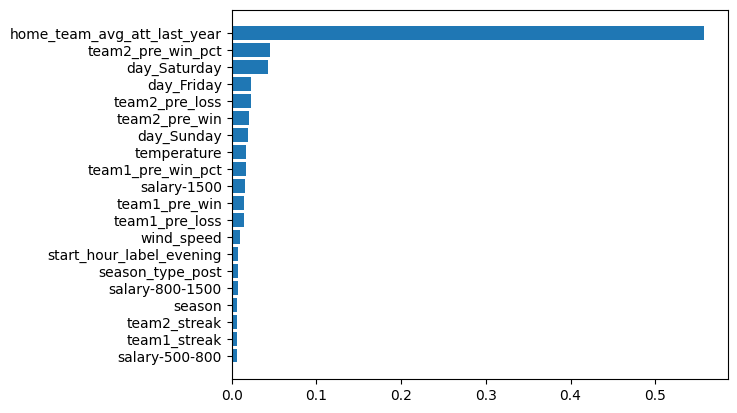

In [37]:
# matplotlib
import matplotlib.pyplot as plt

feature_importances = np.mean([
    tree.feature_importances_ for tree in regr.estimators_
], axis=0)

num_features = 20

indices = np.argsort(feature_importances)[::-1][:num_features]

fig, ax = plt.subplots()
ax.barh(range(num_features), feature_importances[indices][::-1])
ax.set_yticks(range(num_features))
_ = ax.set_yticklabels(np.array(X.columns)[indices][::-1])
# font size
plt.rcParams.update({'font.size': 8})

### Hyperparameter Tuning

In [45]:
# skf = StratifiedKFold(n_splits=5)
scoring = ['neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error']
n_estimators_grid = np.geomspace(5, 500, 5, endpoint=True, dtype=int) # 10 numbers between 5 and 500
n_estimators_dict = {}

for n_estimators in n_estimators_grid:
    regr = BaggingRegressor(n_estimators=n_estimators, random_state=42)
    results = cross_validate(regr, X, y, cv=5, scoring=scoring, return_train_score=True)

    metric_dict = {}
    metric_dict['MSE'] = results['test_neg_mean_squared_error'].mean()
    metric_dict['RMSE (Train)'] = results['train_neg_root_mean_squared_error'].mean()
    metric_dict['RMSE'] = results['test_neg_root_mean_squared_error'].mean()
    metric_dict['MAE'] = results['test_neg_mean_absolute_error'].mean()
    metric_dict['MAPE'] = results['test_neg_mean_absolute_percentage_error'].mean()
    metric_dict['fit_time'] = results['fit_time'].mean()
    metric_dict['score_time'] = results['score_time'].mean()

    n_estimators_dict[n_estimators] = metric_dict

### Use the best hyperparameters to train the model

In [46]:
metric_df = pd.DataFrame(n_estimators_dict).T.reset_index().rename(columns={'index': 'n_estimators'})
metric_df

,n_estimators,MSE,RMSE (Train),RMSE,MAE,MAPE,fit_time,score_time
0,5,-3.508660e+07,-2248.654698,-5916.830610,-4444.372029,-0.185523,2.269422,0.051084
1,15,-3.174788e+07,-1850.854663,-5625.651302,-4229.927069,-0.176812,5.147037,0.078979
2,49,-3.065770e+07,-1678.355158,-5527.407774,-4146.482850,-0.173714,14.546918,0.236697
3,158,-3.027782e+07,-1626.239790,-5493.790275,-4120.761142,-0.172471,48.639971,0.767320
4,500,-3.013973e+07,-1611.524880,-5481.823852,-4107.168275,-0.171615,146.573884,2.517257


In [47]:
best_grid = metric_df[abs(metric_df['RMSE']) == abs(metric_df['RMSE']).min()]
best_rmse = best_grid['RMSE'].values[0]
best_nest = best_grid['n_estimators'].values[0]

print(f'Best number of trees = {best_nest} with RMSE = {best_rmse}')

Best number of trees = 500 with RMSE = -5481.823852206085


In [48]:
# regr = BaggingRegressor(n_estimators=1000, random_state=0).fit(scaled_X, y) # too big
best_nest = 49
regr = BaggingRegressor(n_estimators=best_nest, random_state=0).fit(X, y) # fit time 爆炸成長前

In [49]:
# save model in YYYYMMDD format
from datetime import datetime
import pickle

regr_filename = f'{datetime.today().strftime("%Y%m%d")}_bagging_model_49.pkl'
pickle.dump(regr, open(regr_filename, 'wb'))

### Feature Importance

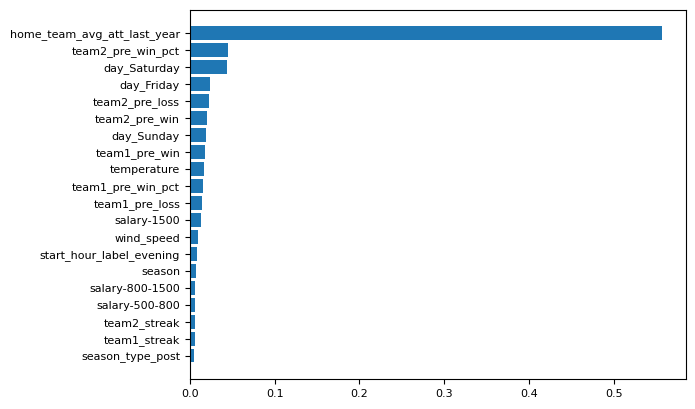

In [56]:
# matplotlib
import matplotlib.pyplot as plt

feature_importances = np.mean([
    tree.feature_importances_ for tree in regr.estimators_
], axis=0)

num_features = 20

indices = np.argsort(feature_importances)[::-1][:num_features]

fig, ax = plt.subplots()
ax.barh(range(num_features), feature_importances[indices][::-1])
ax.set_yticks(range(num_features))
_ = ax.set_yticklabels(np.array(X.columns)[indices][::-1])
# font size
plt.rcParams.update({'font.size': 8})

## Model Evaluation

In [54]:
X_test, y_test = raw_test_df.drop(columns=['attendance'], axis=1), raw_test_df['attendance']

In [55]:
# read model
import pickle
regr = pickle.load(open('20221126_bagging_model_49.pkl', 'rb'))
y_pred = regr.predict(X_test)

# performance
test_performance = measure_model(y_test, y_pred, title='Bagging Regressor')

========== Bagging Regressor ==========
MSE: 44278142.04
RMSE: 6654.18
MAE: 5128.62
MAPE: 0.26


Note:

+ The model does a pretty ok job with bagging, but still can be improved through following ways:
    1. Player data may be too noisy, we can try to cut down player features with PCA or maybe just use salary ranks
    2. Venue capacities vary a lot, it'd be better if we can first group venues by capacity and then train models for each group
+ During hyper-parameter tuning session, 
    + metrics looked good on the training set, but not on the testing set 
    + when n gets larger, the model starts to overfit
    + **Synthesis**: the model is probably overfitting. We can try to reduce the number of features or use regularization to reduce overfitting
+ When comparing the bagging model with the baseline model, we see that baseline (MA-5) did slightly better, but it does way better than **average attendance of a stadium**. 
+ `home team avg att last year` is the most important feature, which makes sense, but may have to 

```
==================== MA(5) ====================
MSE:  32362577.913605437
RMSE:  5688.81164335799
MAE:  4399.588064076346
MAPE 0.21121206067333725
```

```
==================== Average Attendance Only ====================
MSE:  88887032.10373585
RMSE:  9427.991944403424
MAE:  7635.267692974473
MAPE 0.48553017390069386
```

```
========== Bagging Regressor ==========
MSE: 44278142.04
RMSE: 6654.18
MAE: 5128.62
MAPE: 0.26
```